<a href="https://colab.research.google.com/github/WahyuKhairi06/BigData_2311531009_Wahyu-Khairi/blob/main/Tugas%20Akhir%20Big%20Data/Naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rajatkumar30_fake_news_path = kagglehub.dataset_download('rajatkumar30/fake-news')

print('Data source import complete.')


100%|██████████| 11.5M/11.5M [00:00<00:00, 103MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Data distribution:
label
REAL    3154
FAKE    3152
Name: count, dtype: int64


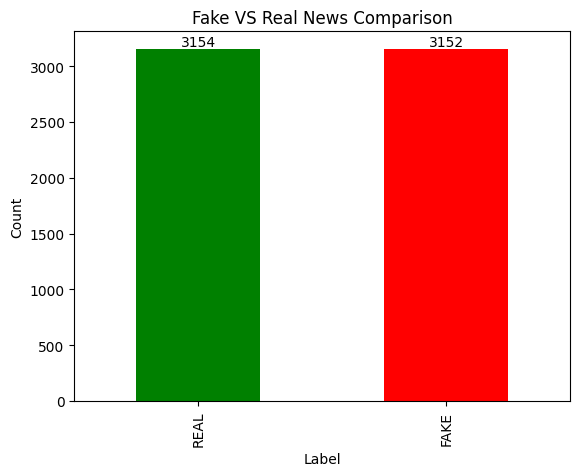


Cleaning text data...

Label encoding:
label  label_encoded
REAL   1                3154
FAKE   0                3152
Name: count, dtype: int64

Train set size: 5044
Test set size: 1262

Creating TF-IDF features...
TF-IDF Train shape: (5044, 5000)
TF-IDF Test shape: (1262, 5000)

NAIVE BAYES MODEL TRAINING

Model Performance:
Accuracy:  0.8788
Precision: 0.9051
Recall:    0.8463
F1-Score:  0.8747

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.86      0.91      0.88       631
        REAL       0.91      0.85      0.87       631

    accuracy                           0.88      1262
   macro avg       0.88      0.88      0.88      1262
weighted avg       0.88      0.88      0.88      1262



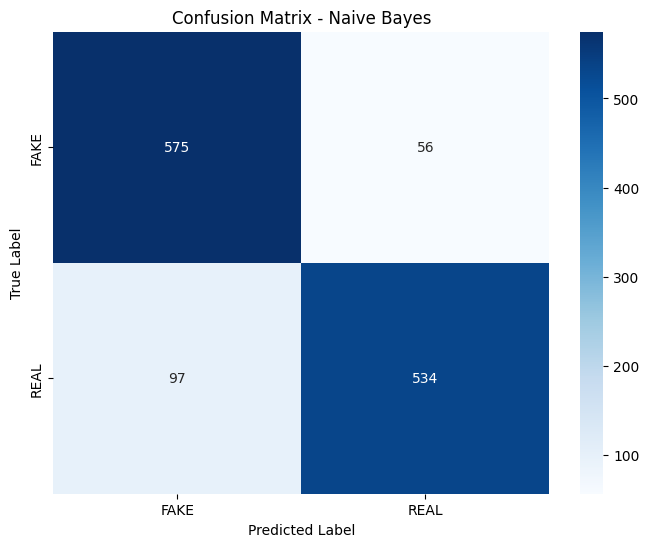


FEATURE IMPORTANCE ANALYSIS

Top features for FAKE news:
 1. trump                - -5.3119
 2. clinton              - -5.4114
 3. hillary              - -5.6091
 4. us                   - -5.7387
 5. people               - -5.9855
 6. election             - -6.0505
 7. one                  - -6.1552
 8. fbi                  - -6.1575
 9. would                - -6.1836
10. russia               - -6.1899
11. said                 - -6.2040
12. world                - -6.2245
13. hillary clinton      - -6.2553
14. new                  - -6.2689
15. october              - -6.3100
16. war                  - -6.3474
17. like                 - -6.3851
18. media                - -6.4417
19. government           - -6.4613
20. emails               - -6.4700

Top features for REAL news:
 1. trump                - -5.0360
 2. said                 - -5.2227
 3. clinton              - -5.4517
 4. obama                - -5.8586
 5. sanders              - -5.9446
 6. would                - -5.9863
 7.

In [5]:
# Import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords jika belum
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added to download the missing resource

# Load dataset
# df = pd.read_csv('/kaggle/input/fake-news/news.csv') # Original line
df = pd.read_csv(rajatkumar30_fake_news_path + '/news.csv') # Corrected line

# Rename column
df.rename(columns = {'Unnamed: 0': 'ID'}, inplace = True)

# Remove duplicates
df = df.drop_duplicates(subset=['text','title'])

# Check data distribution
print("Data distribution:")
print(df['label'].value_counts())

# Bar chart Fake vs Real Comparison
bar = df['label'].value_counts().plot(kind='bar',color=['green','red'])
for i in bar.patches:
    bar.text(i.get_x() + i.get_width()/2,i.get_height() + 0.1,
            f'{int(i.get_height())}',
            ha='center',va='bottom')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Fake VS Real News Comparison')
plt.show()

# ==============================
# DATA PREPROCESSING
# ==============================

# Combine title and text
df['content'] = df['title'] + ' ' + df['text']

# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply cleaning
print("\nCleaning text data...")
df['clean_content'] = df['content'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
# REAL = 1, FAKE = 0
print("\nLabel encoding:")
print(df[['label', 'label_encoded']].value_counts())

# ==============================
# FEATURE EXTRACTION - TF-IDF
# ==============================

# Split data
X = df['clean_content']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Create TF-IDF features
print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Train shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test shape: {X_test_tfidf.shape}")

# ==============================
# NAIVE BAYES MODEL
# ==============================

print("\n" + "="*50)
print("NAIVE BAYES MODEL TRAINING")
print("="*50)

# Initialize and train Naive Bayes
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = nb_model.predict(X_test_tfidf)
y_pred_prob = nb_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['FAKE', 'REAL'],
            yticklabels=['FAKE', 'REAL'])
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ==============================
# FEATURE IMPORTANCE ANALYSIS
# ==============================

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature names and log probabilities
feature_names = tfidf_vectorizer.get_feature_names_out()
log_prob = nb_model.feature_log_prob_

# Get top features for each class
top_n = 20
print("\nTop features for FAKE news:")
fake_idx = np.argsort(log_prob[0])[-top_n:][::-1]
for i, idx in enumerate(fake_idx):
    print(f"{i+1:2d}. {feature_names[idx]:20s} - {log_prob[0][idx]:.4f}")

print("\nTop features for REAL news:")
real_idx = np.argsort(log_prob[1])[-top_n:][::-1]
for i, idx in enumerate(real_idx):
    print(f"{i+1:2d}. {feature_names[idx]:20s} - {log_prob[1][idx]:.4f}")

# ==============================
# CROSS-VALIDATION
# ==============================

print("\n" + "="*50)
print("CROSS-VALIDATION")
print("="*50)

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(nb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (5-fold): {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# ==============================
# HYPERPARAMETER TUNING
# ==============================

print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

# Grid search
grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_nb = grid_search.best_estimator_
best_nb.fit(X_train_tfidf, y_train)

# Evaluate best model
y_pred_best = best_nb.predict(X_test_tfidf)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"\nBest model test accuracy: {best_accuracy:.4f}")
print(f"Improvement: {(best_accuracy - accuracy):.4f}")

# ==============================
# ERROR ANALYSIS
# ==============================

print("\n" + "="*50)
print("ERROR ANALYSIS")
print("="*50)

# Create dataframe for analysis
results_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Predicted_Label': y_pred,
    'Content': X_test.values
})

# Convert encoded labels back to original
results_df['True_Label_Text'] = results_df['True_Label'].map({0: 'FAKE', 1: 'REAL'})
results_df['Predicted_Label_Text'] = results_df['Predicted_Label'].map({0: 'FAKE', 1: 'REAL'})

# Find misclassified examples
misclassified = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
print(f"\nNumber of misclassified samples: {len(misclassified)} ({len(misclassified)/len(y_test)*100:.2f}%)")

# Show some misclassified examples
print("\nExamples of misclassified news:")
for i, (idx, row) in enumerate(misclassified.head(5).iterrows()):
    print(f"\nExample {i+1}:")
    print(f"True Label: {row['True_Label_Text']}")
    print(f"Predicted: {row['Predicted_Label_Text']}")
    content_preview = row['Content'][:200] + "..." if len(row['Content']) > 200 else row['Content']
    print(f"Content Preview: {content_preview}")
    print("-" * 50)

# ==============================
# MODEL PERSISTENCE
# ==============================

print("\n" + "="*50)
print("MODEL SAVING")
print("="*50)

import joblib
import os

# Create directory for saving models
os.makedirs('models', exist_ok=True)

# Save the model and vectorizer
joblib.dump(best_nb, 'models/naive_bayes_model.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("Model, vectorizer, and label encoder saved successfully!")

# ==============================
# PREDICTION FUNCTION
# ==============================

def predict_news(text):
    """
    Function to predict if a news article is fake or real
    """
    # Clean the text
    cleaned_text = clean_text(text)

    # Transform using TF-IDF
    text_tfidf = tfidf_vectorizer.transform([cleaned_text])

    # Make prediction
    prediction = best_nb.predict(text_tfidf)
    probability = best_nb.predict_proba(text_tfidf)

    # Get label
    label = label_encoder.inverse_transform(prediction)[0]

    return {
        'prediction': label,
        'probability_fake': probability[0][0],
        'probability_real': probability[0][1],
        'is_fake': label == 'FAKE'
    }

# Test the prediction function
print("\n" + "="*50)
print("TEST PREDICTION")
print("="*50)

# Example test cases
test_cases = [
    "Breaking news: Scientists discover new treatment for cancer that shows 95% success rate in trials.",
    "Aliens have landed in New York City and are taking over government buildings, says anonymous source.",
    "The president announced new economic policies aimed at reducing inflation and creating jobs."
]

for i, test_text in enumerate(test_cases):
    result = predict_news(test_text)
    print(f"\nTest Case {i+1}:")
    print(f"Text: {test_text[:100]}...")
    print(f"Prediction: {result['prediction']}")
    print(f"Probability (Fake): {result['probability_fake']:.4f}")
    print(f"Probability (Real): {result['probability_real']:.4f}")

# ==============================
# PERFORMANCE SUMMARY
# ==============================

print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)

print(f"\nDataset Statistics:")
print(f"Total samples: {len(df)}")
print(f"Fake news: {len(df[df['label']=='FAKE'])}")
print(f"Real news: {len(df[df['label']=='REAL'])}")

print(f"\nModel Performance Summary:")
print(f"Initial Accuracy: {accuracy:.4f}")
print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best):.4f}")

print("\n✓ Preprocessing completed successfully")
print("✓ Naive Bayes model trained and optimized")
print("✓ Model evaluation metrics calculated")
print("✓ Model saved for future use")